# Challenge: Boston marathon

Pick a year and perform clustering on performance data from the Boston marathon.

Which clustering solution (including number of clusters and algorithm used) is best for the marathon data? Write a data story, including visualizations, to teach the reader something about the Boston Marathon based on your clusters.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

from sklearn import metrics
from itertools import cycle

import matplotlib.cm as cm

from sklearn import metrics
from sklearn.metrics import pairwise_distances

Import data from 2014 and take a preliminary look at features and quantities. This data comes from the 2014 report on performance results from the Boston marathon. The Boston marathon is one of the world's largest marathons, attracting competitive runners from all around the world. The marathon is open to men and women, though they are separated into different divisions. Using the features available, I will attempt to group this large dataset into sensible clusters.

In [2]:
boston2014 = pd.read_csv('boston2014.csv')

print(boston2014.shape)
pd.set_option('display.max_columns', None)
print(boston2014.head())
print(boston2014.dtypes)

print(len(boston2014.loc[boston2014['gender'] == 'M']))
print(len(boston2014.loc[boston2014['gender'] == 'F']))

(31984, 21)
     10k                name  division    25k gender  age  official bib  \
0  17.37  Yamamoto, Hiroyuki         8  47.67      M   47     85.25  W1   
1  32.58        Jeptoo, Rita         1  82.43      F   33    138.95  F1   
2  16.62   Van Dyk, Ernst F.         1  45.80      M   41     80.60  W2   
3  32.57        Dibaba, Mare         3  82.43      F   24    140.58  F2   
4  17.12      Hokinoue, Kota         2  46.37      M   40     81.23  W3   

   genderdiv  ctz     35k  overall  pace state    30k     5k   half    20k  \
0          8  NaN   71.40        8  3.27   NaN  59.18   8.02  39.72  37.65   
1          1  NaN  116.37       21  5.30   NaN  99.33  16.22  69.47  65.83   
2          1  NaN   67.42        1  3.08   NaN  56.45   7.75  38.03  36.10   
3          3  NaN  116.37       27  5.37   NaN  99.33  16.20  69.47  65.83   
4          2  NaN   67.83        2  3.10   NaN  57.03   8.02  38.60  36.58   

  country            city     40k  
0     JPN         Fukuoka   80.4

We have 31984 observations, with 21 features. We can see information about their performance, including timing from 5k, 10k, 20k, 25k, 30k, 35k, and 40k distances, and average pace. We can see information about each contestant, such as name, gender, age, and place of origin. A few categories represent administrative details about the marathon, such as assigned division. I could not find any literature explaining what genderdiv represents.  <br>

Let's make sure all numeric categories are converted to numeric.

In [3]:
numeric = ['10k','25k','age','official','35k','overall','pace','30k','5k','half','20k','40k']
boston2014[numeric] = boston2014[numeric].apply(pd.to_numeric, errors = 'coerce', axis=1)
print(boston2014.dtypes)

10k          float64
name          object
division       int64
25k          float64
gender        object
age          float64
official     float64
bib           object
genderdiv      int64
ctz           object
35k          float64
overall      float64
pace         float64
state         object
30k          float64
5k           float64
half         float64
20k          float64
country       object
city          object
40k          float64
dtype: object


Now, let's see what kinds of values are comprising the non-numeric features.

In [4]:
categorical = ['gender','bib','ctz','state','country','city']

for column in categorical:
    print(boston2014[column].value_counts())

M    17617
F    14367
Name: gender, dtype: int64
17502    1
10758    1
10466    1
2110     1
3343     1
28984    1
14003    1
11161    1
5235     1
23319    1
28370    1
4255     1
4174     1
33923    1
15059    1
15005    1
19254    1
26424    1
30693    1
10604    1
11754    1
22355    1
14316    1
29771    1
11619    1
20588    1
27840    1
34932    1
14920    1
31945    1
        ..
17992    1
3176     1
16300    1
25736    1
14496    1
2632     1
21223    1
23620    1
28548    1
35762    1
33560    1
9760     1
5254     1
18179    1
35186    1
23190    1
11702    1
20291    1
30419    1
29511    1
1975     1
32732    1
4161     1
31589    1
7529     1
24963    1
3808     1
25602    1
2986     1
1394     1
Name: bib, dtype: int64
GBR    171
CAN    143
USA    135
JPN     95
IRL     68
MEX     62
GER     55
FRA     45
AUS     43
CHN     39
ITA     30
NZL     27
NED     22
VEN     19
ESP     18
KOR     17
IND     15
SUI     13
COL     13
SWE     12
ARG     10
BRA     10
RUS      8
ECU

Gender is a useful feature that we can easily convert to binary for analysis purposes.<br>
'Bib' refers to the ranking for that divison. However, since the ranking system is not uniform across divisions, we cannot use this in our algorithm. Some values are strings, some values are numeric, and there is no way to standardize or separate these so we will drop this category from our analysis.<br>
I am not sure what the difference is between ctz and country; the UK is the most common country for ctz, with Canada and USA after. For the country category, USA is the most common country by tenfold, and the frequencies are much higher.<br>
Only American contestants have a value for state. Massachusetts is the most common state, with California and New York next. This makes sense because the marathon is held in Massachusetts. Because this feature doesn't apply to many of the contestants, it will likely not used in the final algorithm.<br>
I doubt city will be a strong category since there are only a few contestants from each and far too many values. I will drop it at this time.<br>
I will also drop name because it should have no effect on the outcome.<br>

Overall, I think it is best to drop all non-numeric features from the analysis. It is difficult to perform clustering on such features, and there are so many values with minimal or imbalanced frequencies. I will also drop all rows that contain NaN values for the features we are clustering on.

In [5]:
boston2014['gender_bin'] = boston2014['gender']
boston2014['gender_bin'] = boston2014['gender_bin'].str.replace('M','0')
boston2014['gender_bin'] = boston2014['gender_bin'].str.replace('F','1')
boston2014['gender_bin'] = pd.to_numeric(boston2014['gender_bin'], errors='coerce')

drop = ['name','gender','bib','ctz','state','country','city']
numeric.append('gender_bin')
dropna2014 = boston2014.dropna(subset = numeric)
print(len(dropna2014))

continuous2014 = dropna2014.drop(drop, axis=1)
print(continuous2014.dtypes)
print(continuous2014.head())

['10k', '25k', 'age', 'official', '35k', 'overall', 'pace', '30k', '5k', 'half', '20k', '40k', 'gender_bin']
31649
10k           float64
division        int64
25k           float64
age           float64
official      float64
genderdiv       int64
35k           float64
overall       float64
pace          float64
30k           float64
5k            float64
half          float64
20k           float64
40k           float64
gender_bin      int64
dtype: object
     10k  division    25k   age  official  genderdiv     35k  overall  pace  \
0  17.37         8  47.67  47.0     85.25          8   71.40      8.0  3.27   
1  32.58         1  82.43  33.0    138.95          1  116.37     21.0  5.30   
2  16.62         1  45.80  41.0     80.60          1   67.42      1.0  3.08   
3  32.57         3  82.43  24.0    140.58          3  116.37     27.0  5.37   
4  17.12         2  46.37  40.0     81.23          2   67.83      2.0  3.10   

     30k     5k   half    20k     40k  gender_bin  
0  59.18   8.0

Great! Now let's dive into the data. We have enough data that eliminating rows with null values wasn't an issue (we only lost about 300 values out of 30000). Now, to evaluate our various clustering solutions, we need to split our data into 4 subsets so we can compare them against eachother for consistency. We will also normalize the data so we can use PCA to reduce it to 2 components for visualization purposes.

In [6]:
def set_X_groups(df):
    
    X = df
    rows = X.shape[0] - X.shape[0] % 4
    X = X.iloc[:rows, :]
    X_norm = normalize(X)
    print(X.shape)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_norm)

    X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
        X_norm,
        X_pca,
        test_size=0.5,
        random_state=42)

    X1, X2, X_pca1, X_pca2 = train_test_split(
        X_half1,
        X_pcahalf1,
        test_size=0.5,
        random_state=42)
    X3, X4, X_pca3, X_pca4 = train_test_split(
        X_half2,
        X_pcahalf2,
        test_size=0.5,
        random_state=42)
    
    return X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4

X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4 = set_X_groups(continuous2014)

(31648, 15)


# K Means

Because K-means requires us to specify clusters, we will have to iterate through various quantities for cluster assignments.<br>
For each data subset, create a new dataframe for plotting with the PCA X/Y coordinates per each datapoint.<br>
For each subsample, iterate through all possible numbers of clusters.<br>
Train the model with the full dataset and append cluster predictions to the reduced dataset for plotting.<br>
Calculate the mean silhouette score for all points in that subsample/cluster combo.<br><br>

The silhouette score is a common measure to evaluate clusters that have no "ground truth". Instead of comparing our clusters to known values, we split the data into subsets and cluster on each subset. We can then find a silhouette score per each subset, which provides information on how consistently the algorithm clustered that data. If we can't make sure our algorithm is accurate, at least we can make sure it is precise, and clustering similary with each iteration. The silhouette score is calculated by taking the distance from each point to every other point in its cluster, and the distance from that same point to every other point in the nearest cluster. The mean of all points in the dataset represent the silhouette score that can be compared against other datasets.

# Plotting

Specify color palette with nclust values in the rainbow range.<br>
For every cluster number, create a 2x2 plotgrid.<br>
For every cluster number, iterate through all 4 subsets.<br>
Set the row/column position for that subset.<br>
Color code the plot according to the cluster prediction.<br>
Append the silhouette score for that subsample/cluster combo to a list of silhouette scores for that cluster number.<br>

scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097


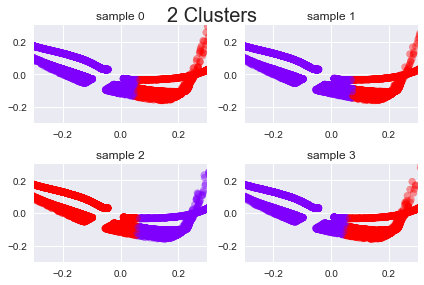



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580


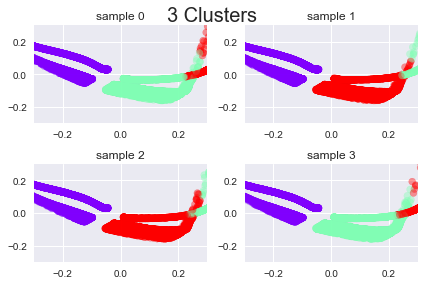



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009


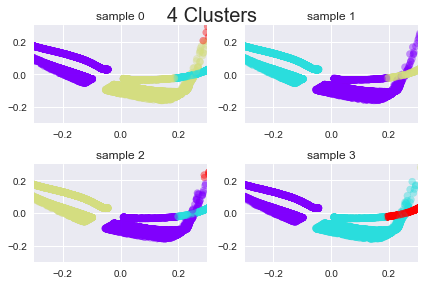



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892


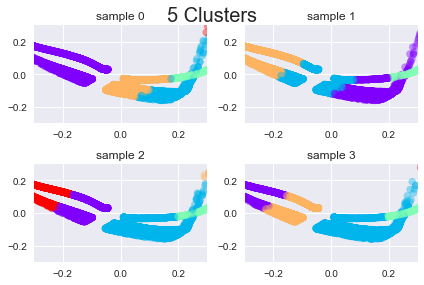



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892
4       6.0    0.450663  0.003008


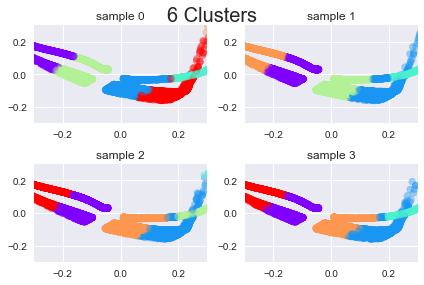



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892
4       6.0    0.450663  0.003008
5       7.0    0.527788  0.003477


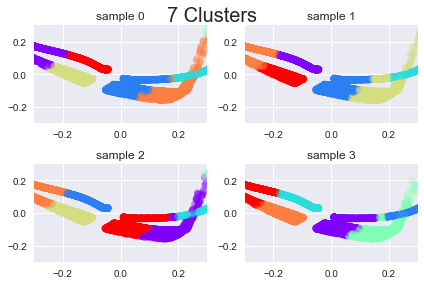



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892
4       6.0    0.450663  0.003008
5       7.0    0.527788  0.003477
6       8.0    0.533154  0.002232


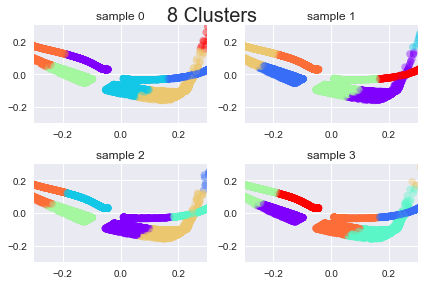



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892
4       6.0    0.450663  0.003008
5       7.0    0.527788  0.003477
6       8.0    0.533154  0.002232
7       9.0    0.558038  0.001363


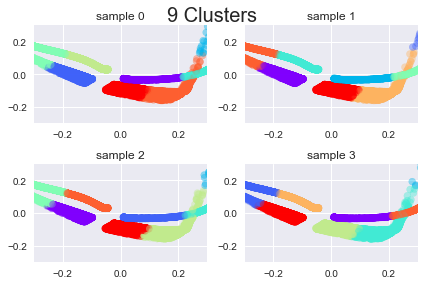



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892
4       6.0    0.450663  0.003008
5       7.0    0.527788  0.003477
6       8.0    0.533154  0.002232
7       9.0    0.558038  0.001363
8      10.0    0.553931  0.006278


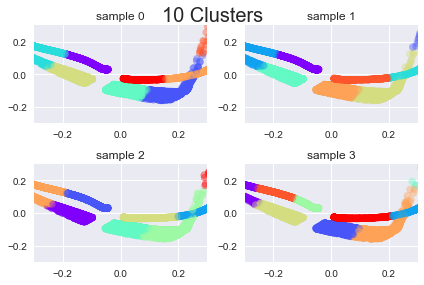



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892
4       6.0    0.450663  0.003008
5       7.0    0.527788  0.003477
6       8.0    0.533154  0.002232
7       9.0    0.558038  0.001363
8      10.0    0.553931  0.006278
9      11.0    0.555869  0.001732


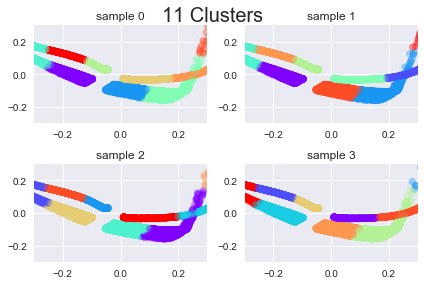



scores:
    clusters  mean score       std
0        2.0    0.454315  0.007097
1        3.0    0.477944  0.003580
2        4.0    0.495246  0.002009
3        5.0    0.437714  0.023892
4        6.0    0.450663  0.003008
5        7.0    0.527788  0.003477
6        8.0    0.533154  0.002232
7        9.0    0.558038  0.001363
8       10.0    0.553931  0.006278
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099


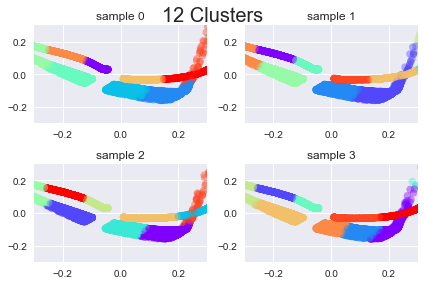



scores:
    clusters  mean score       std
0        2.0    0.454315  0.007097
1        3.0    0.477944  0.003580
2        4.0    0.495246  0.002009
3        5.0    0.437714  0.023892
4        6.0    0.450663  0.003008
5        7.0    0.527788  0.003477
6        8.0    0.533154  0.002232
7        9.0    0.558038  0.001363
8       10.0    0.553931  0.006278
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099
11      13.0    0.549027  0.012397


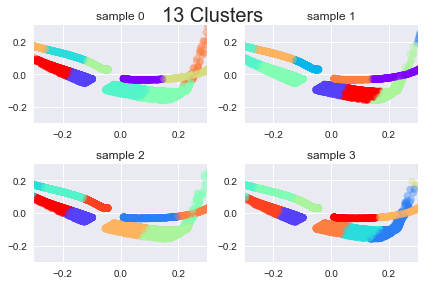



scores:
    clusters  mean score       std
0        2.0    0.454315  0.007097
1        3.0    0.477944  0.003580
2        4.0    0.495246  0.002009
3        5.0    0.437714  0.023892
4        6.0    0.450663  0.003008
5        7.0    0.527788  0.003477
6        8.0    0.533154  0.002232
7        9.0    0.558038  0.001363
8       10.0    0.553931  0.006278
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099
11      13.0    0.549027  0.012397
12      14.0    0.548840  0.012920


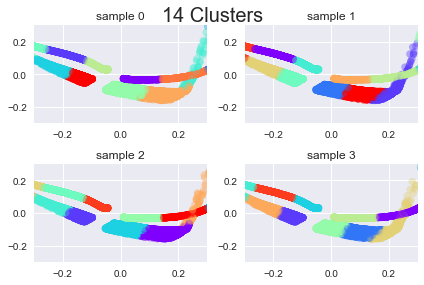



scores:
    clusters  mean score       std
0        2.0    0.454315  0.007097
1        3.0    0.477944  0.003580
2        4.0    0.495246  0.002009
3        5.0    0.437714  0.023892
4        6.0    0.450663  0.003008
5        7.0    0.527788  0.003477
6        8.0    0.533154  0.002232
7        9.0    0.558038  0.001363
8       10.0    0.553931  0.006278
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099
11      13.0    0.549027  0.012397
12      14.0    0.548840  0.012920
13      15.0    0.544838  0.003101


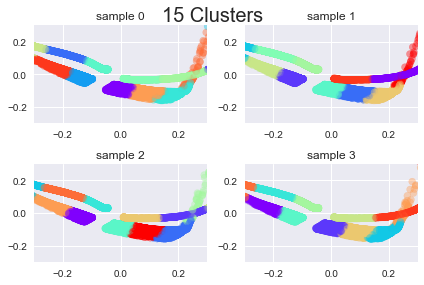



scores:
    clusters  mean score       std
0        2.0    0.454315  0.007097
1        3.0    0.477944  0.003580
2        4.0    0.495246  0.002009
3        5.0    0.437714  0.023892
4        6.0    0.450663  0.003008
5        7.0    0.527788  0.003477
6        8.0    0.533154  0.002232
7        9.0    0.558038  0.001363
8       10.0    0.553931  0.006278
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099
11      13.0    0.549027  0.012397
12      14.0    0.548840  0.012920
13      15.0    0.544838  0.003101
14      16.0    0.545541  0.002119


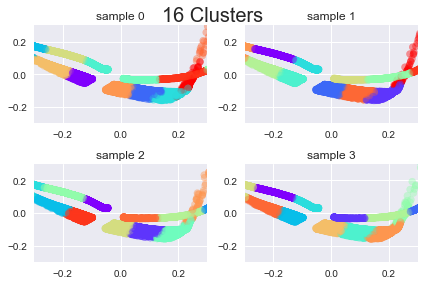



scores:
    clusters  mean score       std
0        2.0    0.454315  0.007097
1        3.0    0.477944  0.003580
2        4.0    0.495246  0.002009
3        5.0    0.437714  0.023892
4        6.0    0.450663  0.003008
5        7.0    0.527788  0.003477
6        8.0    0.533154  0.002232
7        9.0    0.558038  0.001363
8       10.0    0.553931  0.006278
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099
11      13.0    0.549027  0.012397
12      14.0    0.548840  0.012920
13      15.0    0.544838  0.003101
14      16.0    0.545541  0.002119
15      17.0    0.540080  0.010165


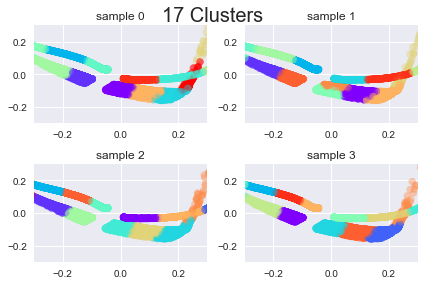



scores:
    clusters  mean score       std
0        2.0    0.454315  0.007097
1        3.0    0.477944  0.003580
2        4.0    0.495246  0.002009
3        5.0    0.437714  0.023892
4        6.0    0.450663  0.003008
5        7.0    0.527788  0.003477
6        8.0    0.533154  0.002232
7        9.0    0.558038  0.001363
8       10.0    0.553931  0.006278
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099
11      13.0    0.549027  0.012397
12      14.0    0.548840  0.012920
13      15.0    0.544838  0.003101
14      16.0    0.545541  0.002119
15      17.0    0.540080  0.010165
16      18.0    0.533278  0.017180


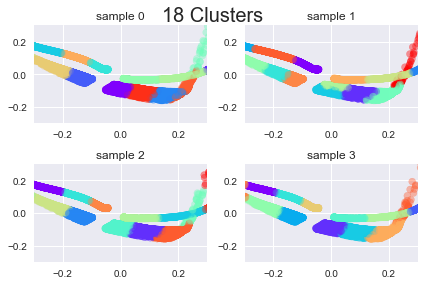



scores:
    clusters  mean score       std
0        2.0    0.454315  0.007097
1        3.0    0.477944  0.003580
2        4.0    0.495246  0.002009
3        5.0    0.437714  0.023892
4        6.0    0.450663  0.003008
5        7.0    0.527788  0.003477
6        8.0    0.533154  0.002232
7        9.0    0.558038  0.001363
8       10.0    0.553931  0.006278
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099
11      13.0    0.549027  0.012397
12      14.0    0.548840  0.012920
13      15.0    0.544838  0.003101
14      16.0    0.545541  0.002119
15      17.0    0.540080  0.010165
16      18.0    0.533278  0.017180
17      19.0    0.529320  0.008982


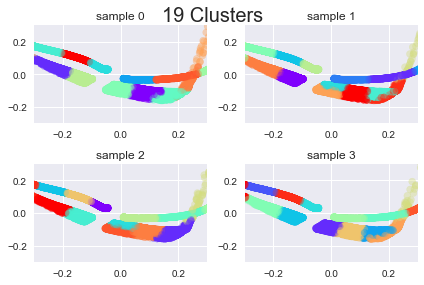



scores:
    clusters  mean score       std
0        2.0    0.454315  0.007097
1        3.0    0.477944  0.003580
2        4.0    0.495246  0.002009
3        5.0    0.437714  0.023892
4        6.0    0.450663  0.003008
5        7.0    0.527788  0.003477
6        8.0    0.533154  0.002232
7        9.0    0.558038  0.001363
8       10.0    0.553931  0.006278
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099
11      13.0    0.549027  0.012397
12      14.0    0.548840  0.012920
13      15.0    0.544838  0.003101
14      16.0    0.545541  0.002119
15      17.0    0.540080  0.010165
16      18.0    0.533278  0.017180
17      19.0    0.529320  0.008982
18      20.0    0.523120  0.001375


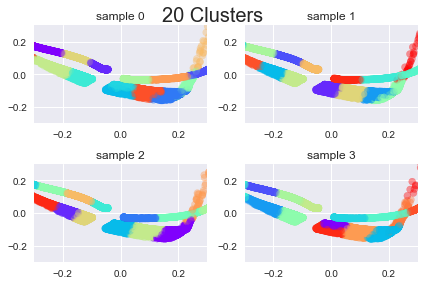



sorted cluster scores:
    clusters  mean score       std
7        9.0    0.558038  0.001363
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099
8       10.0    0.553931  0.006278
11      13.0    0.549027  0.012397
12      14.0    0.548840  0.012920
14      16.0    0.545541  0.002119
13      15.0    0.544838  0.003101
15      17.0    0.540080  0.010165
16      18.0    0.533278  0.017180
6        8.0    0.533154  0.002232
17      19.0    0.529320  0.008982
5        7.0    0.527788  0.003477
18      20.0    0.523120  0.001375
2        4.0    0.495246  0.002009
1        3.0    0.477944  0.003580
0        2.0    0.454315  0.007097
4        6.0    0.450663  0.003008
3        5.0    0.437714  0.023892
best cluster num:
9


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:63: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [14]:
def evaluate_kmeans(X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4, clust_range):

    plot_clusters = pd.DataFrame()
    cluster_scores = pd.DataFrame(columns=['clusters','mean score','std'])

    for index, data in enumerate([
        (X1, X_pca1),
        (X2, X_pca2),
        (X3, X_pca3),
        (X4, X_pca4)]):

        plot_clusters['pca_f1' + '_sample' + str(index)] = data[1][:, 0]
        plot_clusters['pca_f2' + '_sample' + str(index)] = data[1][:, 1]

        for nclust in range(2, clust_range):
            km = KMeans(n_clusters=nclust, random_state=42)
            km.fit(data[0])
            labels = km.labels_
            cluster_pred = km.predict(data[0])
            plot_clusters['clust' + str(nclust) + '_sample' + str(index)] = cluster_pred
            plot_clusters['sil_score_' + 'clust'+ str(nclust) + '_sample' + str(index)] = \
                                metrics.silhouette_score(data[0], labels, metric='euclidean')

    for nclust in range(2, clust_range):

        colors = cm.rainbow(np.linspace(0, 1, nclust))
        f, plotgrid = plt.subplots(2, 2)
        sil_scores = []

        for i in range(4):

            current_group = (f'clust{nclust}_sample{i}')

            x_plot = plot_clusters[f'pca_f1_sample{i}']
            y_plot = plot_clusters[f'pca_f2_sample{i}']

            c = plot_clusters[current_group]

            rows = int(np.floor(i / 2))
                # 0,0,1,1
            cols = i % 2
                # 0,1,0,1

            plotgrid[rows, cols].scatter(x_plot, y_plot, color = colors[c], alpha = 0.4)
            plotgrid[rows, cols].set_title(f'sample {i}')
            plotgrid[rows, cols].set_xlim([-.3, .3])
            plotgrid[rows, cols].set_ylim([-.3, .3])

            sil_score = plot_clusters['sil_score_' + str(current_group)].mean()
            sil_scores.append(sil_score)

        group_sil_scores_mean = np.mean(sil_scores)
        group_sil_scores_std = np.std(sil_scores)
        cluster_scores = cluster_scores.append({'clusters':int(nclust), 'mean score': group_sil_scores_mean, 'std': group_sil_scores_std}, ignore_index=True)
        print('scores:')
        print(cluster_scores)

        plt.suptitle(f'{nclust} Clusters', fontsize=20)
        plt.tight_layout()
        plt.show()
        print('\n')
    
    print('sorted cluster scores:')
    sorted_scores = cluster_scores.sort(columns = 'mean score', ascending = False)
    print(sorted_scores)

    best_cluster_num = int(sorted_scores['clusters'].iloc[0])
    print('best cluster num:')
    print(best_cluster_num)
    
    return best_cluster_num
    
continuous2014_best_cluster_num = evaluate_kmeans(X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4, 21)



Using 9 clusters gave the highest mean silhouette score (0.558) and the smallest standard deviation (0.001). Not only did it perform the best out of all the iterations, it also performed the most consistently every time. Let's take a deeper look into some summary statistics for each of these 9 clusters.

In [8]:
def investigate_kmeans(X, best_cluster_num):
    best_cluster_pred = KMeans(n_clusters=best_cluster_num, random_state=42).fit_predict(X)
    X_pred = X.copy()
    X_pred['cluster_assignment'] = best_cluster_pred

    cluster_dataframes = {}
    for n_clust in range(best_cluster_num):
        cluster_dataframes[n_clust] = X_pred.loc[X_pred['cluster_assignment'] == n_clust]

    for name, frame in cluster_dataframes.items():
        print(name)
        print(frame.describe())
        
    return X_pred

continuous2014_pred = investigate_kmeans(continuous2014, continuous2014_best_cluster_num)

0
               10k     division          25k          age     official  \
count  2473.000000  2473.000000  2473.000000  2473.000000  2473.000000   
mean     64.501249  5861.073595   174.405512    30.801456   324.470121   
std       5.893924   550.938600    17.566216     5.190681    29.153494   
min      44.900000  4870.000000   117.780000    18.000000   282.380000   
25%      60.800000  5478.000000   162.020000    27.000000   301.080000   
50%      64.080000  5788.000000   172.070000    31.000000   318.600000   
75%      68.050000  6305.000000   185.070000    35.000000   341.500000   
max      94.450000  6979.000000   281.850000    39.000000   534.220000   

          genderdiv          35k       overall         pace          30k  \
count   2473.000000  2473.000000   2473.000000  2473.000000  2473.000000   
mean   14079.043672   263.007926  28746.807117    12.383947   217.389543   
std     1754.727922    25.094422   1732.956680     1.111999    21.624906   
min    11309.000000   183.3

For the first cluster, some things I noticed are that the general mean to standard deviation ratio is about 10:1. The standard deviation was comparatively small for the category "overall", which relates to their ranking. The mean ranking here was 28735, which is pretty low considering the 31648 datapoints. Gender is fairly even with a 0.587 mean and 0.492 standard deviation. The standard deviation was also low for the 5k mark, and high for age. This cluster has the lowest mean age at 31. These people might be beginner runners -- they are the youngest cluster so they may have fewer years of experience under their belt.<br>

For the 2nd cluster, the standard deviation on all the timing checkpoints were much lower, ranging from a mean to standard deviation ratio of 20:1 to 40:1. The SD for the pace was also extremely low (0.22 for a mean of 8). The gender was consistently male here. The standard deviation for the rank was very high (9267) considering the rest of the values. This cluster has the second lowest mean age at 36.

The 3rd cluster also had an even gender divide, with standard deviations on most categories in the 1:15 range. The mean rank was 18925. I am reminded here that overall rank does not determine the athletic ability of the candidate, because men and women are judged by different standards. I might re-run this analysis after separating male and female.

Looking at the 4th cluster has showed me that pace seems to have consistently small standard deviations for pace. Perhaps the algorithm is clustering by pace? The standard deviation for the overall rank is HUGE, 1458 SD compared to 2340 mean. This cluster has more women than men, but there is a strong standard deviation here. This cluster is basically tied for the second lowest mean age at 36, and has the highest mean rank out of all the clusters (2340). This makes sense because younger people tend to be more athletic.

Cluster 5 is all women, with standard deviation ratios around 1:10 to 1:20. The overall rank here was 12319, which is right in the middle of the pack. This might mean that this area is where a large portion of the female contestants lie, as the few standout contestants placed in other clusters where they mixed in with male contestants. The highest-ranking female contestant had an overall rank of 21.

Cluster 6 is a mix, an overall rank of 28916 with a 17% standard deviation. These contestants have the lowest mean ranking of all the clusters (28916). I am also noticing here that not every cluster is the same size, which is how I thought k-means worked? Mean/standard deviation ratios for this cluster are typically around 20:1, with more consistency than other clusters.

The 7th cluster is made up of slightly higher ranking contestants than cluster 6, with an average of 23636 (still towards the bottom of the pool). The gender distribution is evenly divided in this cluster, and standard deviation ratios vary amongst features.

Cluster 8 is fairly high ranking with an overall ranking of 6608, but it has a very high standard deviation at 1490. This cluster is entirely made up of women, so this must be the highest ranking cluster of women. The official finishing time was 200.

The 9th and final cluster is made up of all men with mid-range rankings. The mean official finishing time was 228. The standard deviation ratios varied a lot.

Although there are obvious differences between our clusters, 9 clusters of mixed gender and age doesn't really tell us much about our data. Additionally, the mean silhouette score was only 0.558, which is not great. Given our background knowledge, we know that male and female contestants perform differently, so let's try separating between male and female, then running the clustering algorithm again.

(17484, 15)
scores:
   clusters  mean score       std
0       2.0    0.645758  0.003691


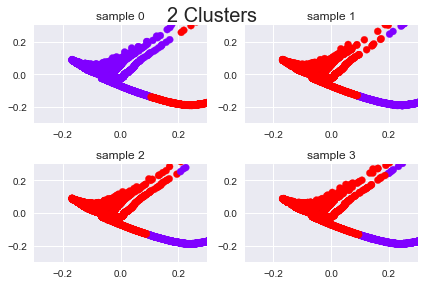



scores:
   clusters  mean score       std
0       2.0    0.645758  0.003691
1       3.0    0.639240  0.003417


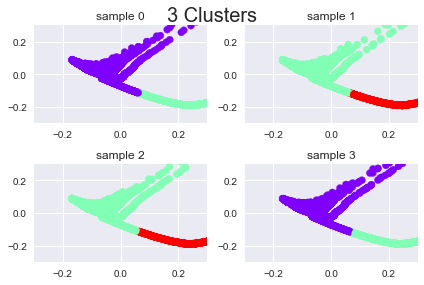



scores:
   clusters  mean score       std
0       2.0    0.645758  0.003691
1       3.0    0.639240  0.003417
2       4.0    0.525565  0.002582


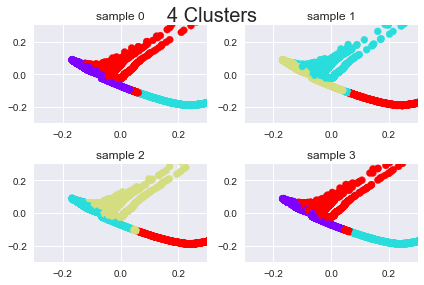



scores:
   clusters  mean score       std
0       2.0    0.645758  0.003691
1       3.0    0.639240  0.003417
2       4.0    0.525565  0.002582
3       5.0    0.533251  0.001528


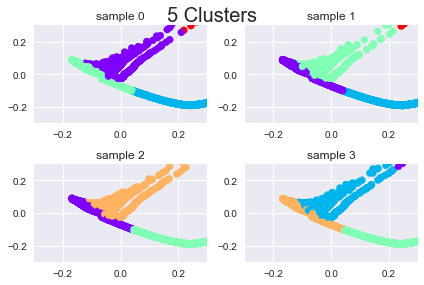



scores:
   clusters  mean score       std
0       2.0    0.645758  0.003691
1       3.0    0.639240  0.003417
2       4.0    0.525565  0.002582
3       5.0    0.533251  0.001528
4       6.0    0.541219  0.001772


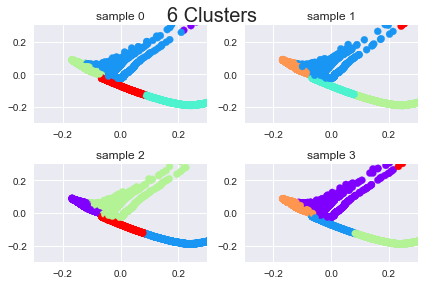



scores:
   clusters  mean score       std
0       2.0    0.645758  0.003691
1       3.0    0.639240  0.003417
2       4.0    0.525565  0.002582
3       5.0    0.533251  0.001528
4       6.0    0.541219  0.001772
5       7.0    0.534906  0.006866


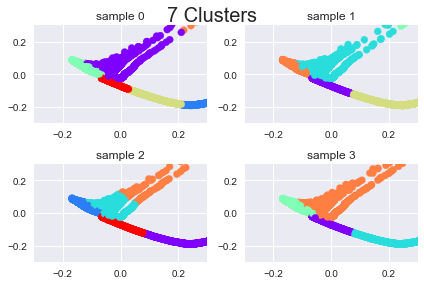



scores:
   clusters  mean score       std
0       2.0    0.645758  0.003691
1       3.0    0.639240  0.003417
2       4.0    0.525565  0.002582
3       5.0    0.533251  0.001528
4       6.0    0.541219  0.001772
5       7.0    0.534906  0.006866
6       8.0    0.535504  0.004568


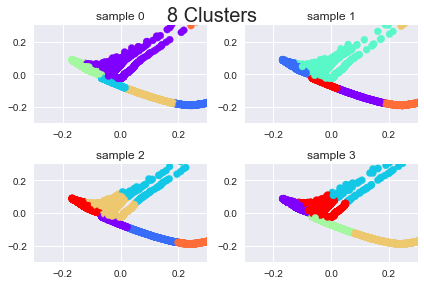



scores:
   clusters  mean score       std
0       2.0    0.645758  0.003691
1       3.0    0.639240  0.003417
2       4.0    0.525565  0.002582
3       5.0    0.533251  0.001528
4       6.0    0.541219  0.001772
5       7.0    0.534906  0.006866
6       8.0    0.535504  0.004568
7       9.0    0.522855  0.015037


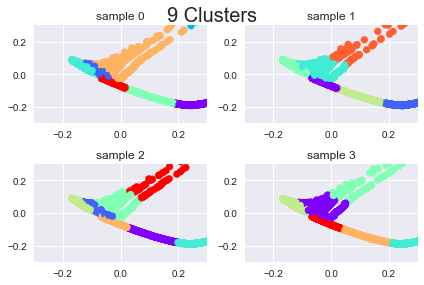



scores:
   clusters  mean score       std
0       2.0    0.645758  0.003691
1       3.0    0.639240  0.003417
2       4.0    0.525565  0.002582
3       5.0    0.533251  0.001528
4       6.0    0.541219  0.001772
5       7.0    0.534906  0.006866
6       8.0    0.535504  0.004568
7       9.0    0.522855  0.015037
8      10.0    0.514143  0.004919


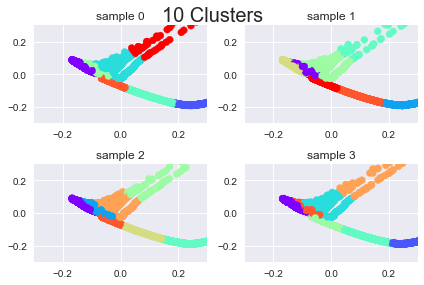



sorted cluster scores:
   clusters  mean score       std
0       2.0    0.645758  0.003691
1       3.0    0.639240  0.003417
4       6.0    0.541219  0.001772
6       8.0    0.535504  0.004568
5       7.0    0.534906  0.006866
3       5.0    0.533251  0.001528
2       4.0    0.525565  0.002582
7       9.0    0.522855  0.015037
8      10.0    0.514143  0.004919
best cluster num:
2
0
               10k     division          25k          age     official  \
count  7857.000000  7857.000000  7857.000000  7857.000000  7857.000000   
mean     56.927763  2409.165330   149.346681    47.793814   278.998912   
std       7.069665  1653.166998    21.236181    12.423349    41.028129   
min      36.870000     1.000000    96.830000    18.000000   226.720000   
25%      51.880000  1107.000000   133.800000    39.000000   244.880000   
50%      56.070000  2058.000000   144.670000    48.000000   269.980000   
75%      61.270000  3920.000000   161.530000    57.000000   304.320000   
max     112.380000  5

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:63: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


               10k     division          25k          age     official  \
count  9627.000000  9627.000000  9627.000000  9627.000000  9627.000000   
mean     43.353105  1180.925522   109.628459    41.827672   194.649023   
std       4.079807   964.827521    10.163376     9.867274    19.436931   
min      16.620000     1.000000    45.800000    18.000000    80.600000   
25%      41.030000   426.000000   103.550000    34.000000   180.850000   
50%      43.250000   953.000000   109.650000    42.000000   195.620000   
75%      46.170000  1619.500000   117.020000    49.000000   209.775000   
max      60.700000  3771.000000   137.430000    76.000000   227.280000   

         genderdiv          35k       overall         pace          30k  \
count  9627.000000  9627.000000   9627.000000  9627.000000  9627.000000   
mean   4781.422873   157.990490   6029.700945     7.432264   133.179762   
std    2787.644024    15.081587   4075.502036     0.741362    12.450865   
min       1.000000    67.420000  

In [9]:
female_cont = continuous2014.loc[continuous2014['gender_bin'] == 0]
f1, f_pca1, f2, f_pca2, f3, f_pca3, f4, f_pca4 = set_X_groups(female_cont)
female_best_cluster_num = evaluate_kmeans(f1, f_pca1, f2, f_pca2, f3, f_pca3, f4, f_pca4, 11)
female_pred = investigate_kmeans(female_cont, female_best_cluster_num)

The cluster arrangement with the highest score for the female group has 2 clusters with a mean silhouette score of 0.646, which is signficantly higher than the mean score for the combined group. This is good! The standard deviation is 3 times higher though, which means the algorithm did not cluster as consistently. Within these 2 clusters, there is a higher ranking group (overall ranking mean 8068) and a lower ranking group (overall ranking mean 23924). Both of these rankings have a standard deviation around 4500, which is very high. The lower ranking female group also has a higher average age, 44, compared to 40 for the higher ranking group.<br>

Let's try male.

state which cluster configurations give best for each --> 
look at distribution of different variables PER EACH CLUSTER, check out previous assignments for inspo
add cluster assignment into original data?

(14164, 15)
scores:
   clusters  mean score       std
0       2.0    0.490907  0.005039


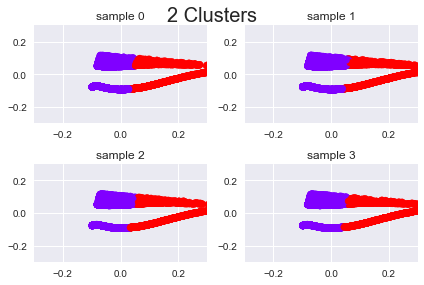



scores:
   clusters  mean score       std
0       2.0    0.490907  0.005039
1       3.0    0.588469  0.003269


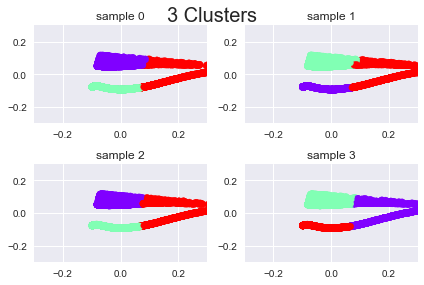



scores:
   clusters  mean score       std
0       2.0    0.490907  0.005039
1       3.0    0.588469  0.003269
2       4.0    0.600356  0.002760


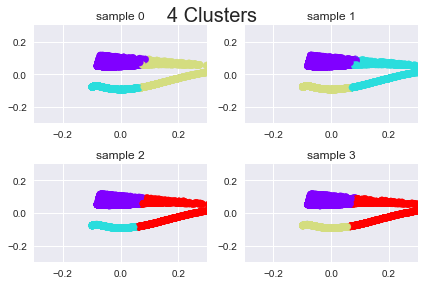



scores:
   clusters  mean score       std
0       2.0    0.490907  0.005039
1       3.0    0.588469  0.003269
2       4.0    0.600356  0.002760
3       5.0    0.610044  0.003035


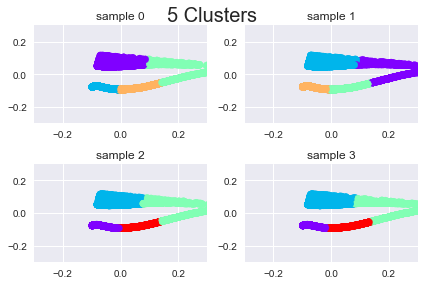



scores:
   clusters  mean score       std
0       2.0    0.490907  0.005039
1       3.0    0.588469  0.003269
2       4.0    0.600356  0.002760
3       5.0    0.610044  0.003035
4       6.0    0.597399  0.003940


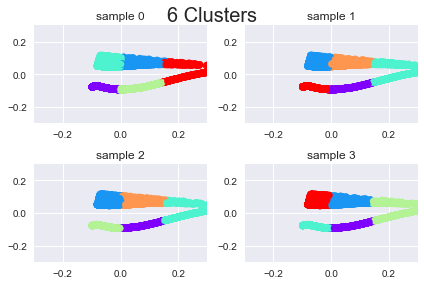



scores:
   clusters  mean score       std
0       2.0    0.490907  0.005039
1       3.0    0.588469  0.003269
2       4.0    0.600356  0.002760
3       5.0    0.610044  0.003035
4       6.0    0.597399  0.003940
5       7.0    0.591212  0.006343


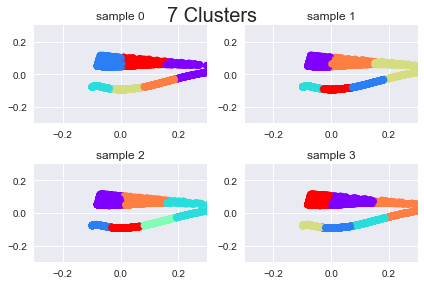



scores:
   clusters  mean score       std
0       2.0    0.490907  0.005039
1       3.0    0.588469  0.003269
2       4.0    0.600356  0.002760
3       5.0    0.610044  0.003035
4       6.0    0.597399  0.003940
5       7.0    0.591212  0.006343
6       8.0    0.581165  0.021352


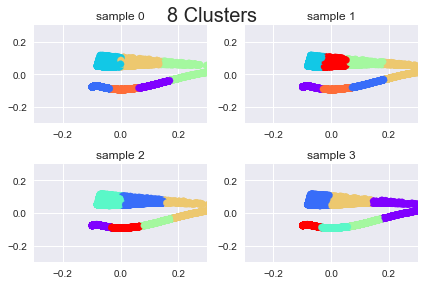



scores:
   clusters  mean score       std
0       2.0    0.490907  0.005039
1       3.0    0.588469  0.003269
2       4.0    0.600356  0.002760
3       5.0    0.610044  0.003035
4       6.0    0.597399  0.003940
5       7.0    0.591212  0.006343
6       8.0    0.581165  0.021352
7       9.0    0.547089  0.006571


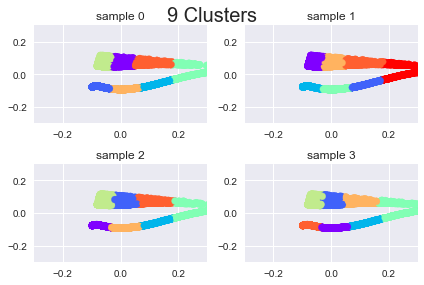



scores:
   clusters  mean score       std
0       2.0    0.490907  0.005039
1       3.0    0.588469  0.003269
2       4.0    0.600356  0.002760
3       5.0    0.610044  0.003035
4       6.0    0.597399  0.003940
5       7.0    0.591212  0.006343
6       8.0    0.581165  0.021352
7       9.0    0.547089  0.006571
8      10.0    0.543220  0.002865


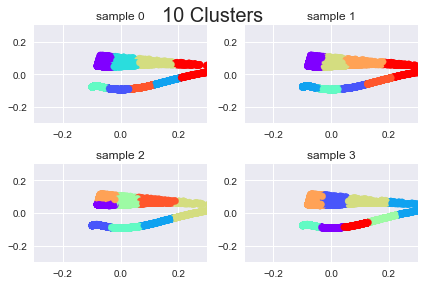



sorted cluster scores:
   clusters  mean score       std
3       5.0    0.610044  0.003035
2       4.0    0.600356  0.002760
4       6.0    0.597399  0.003940
5       7.0    0.591212  0.006343
1       3.0    0.588469  0.003269
6       8.0    0.581165  0.021352
7       9.0    0.547089  0.006571
8      10.0    0.543220  0.002865
0       2.0    0.490907  0.005039
best cluster num:
5


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:63: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


0
               10k     division          25k          age     official  \
count  3055.000000  3055.000000  3055.000000  3055.000000  3055.000000   
mean     49.241673  1481.901800   125.174655    38.505728   220.333964   
std       2.074595  1056.511453     4.090030     8.721359     5.349074   
min      38.500000     1.000000   101.980000    18.000000   210.550000   
25%      47.930000   461.500000   122.580000    32.000000   215.880000   
50%      49.250000  1699.000000   125.030000    39.000000   220.350000   
75%      50.620000  2464.500000   127.950000    45.000000   224.900000   
max      57.270000  3233.000000   138.320000    67.000000   229.980000   

         genderdiv          35k       overall         pace          30k  \
count  3055.000000  3055.000000   3055.000000  3055.000000  3055.000000   
mean   3741.233715   180.232013  12473.499836     8.412062   152.176108   
std     887.391902     4.676012   1618.625288     0.204071     4.424826   
min    2179.000000   160.220000

In [10]:
male_cont = continuous2014.loc[continuous2014['gender_bin'] == 1]
m1, m_pca1, m2, m_pca2, m3, m_pca3, m4, m_pca4 = set_X_groups(male_cont)
male_best_cluster_num = evaluate_kmeans(m1, m_pca1, m2, m_pca2, m3, m_pca3, m4, m_pca4, 11)
male_pred = investigate_kmeans(male_cont, male_best_cluster_num)

The male group looks best with 5 clusters -- this gives a mean silhouette score of 0.61 and a standard deviation of 0.003, similar to that of the female group. The overall ranking varies by about 6000-7000 per group, splitting the male contestants into 5 groups of performers centered around rankings around 3000, 10000, 16000, 22000, and 29000. THe highest ranking group has an average age of 37, then 41, 44, 46, 43 (though the max age here was 81!)

Now that we have our clusters, let's look deeper into the features and see what we can find.

     10k  division    25k   age  official  genderdiv     35k  overall  pace  \
0  17.37         8  47.67  47.0     85.25          8   71.40      8.0  3.27   
2  16.62         1  45.80  41.0     80.60          1   67.42      1.0  3.08   
4  17.12         2  46.37  40.0     81.23          2   67.83      2.0  3.10   
6  17.65         4  47.67  28.0     84.65          4   70.23      4.0  3.23   
7  30.48         5  76.95  29.0    129.83          5  107.47      5.0  4.97   

     30k     5k   half    20k     40k  gender_bin  cluster_assignment  
0  59.18   8.02  39.72  37.65   80.43           0                   1  
2  56.45   7.75  38.03  36.10   76.10           0                   1  
4  57.03   8.02  38.60  36.58   76.72           0                   1  
6  58.60   8.38  39.72  37.65   79.83           0                   1  
7  92.52  15.17  64.85  61.62  122.80           0                   1  
16


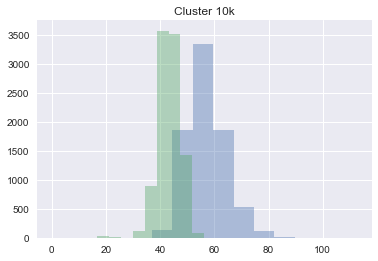

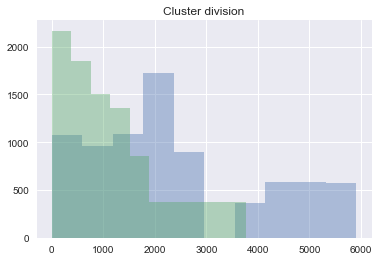

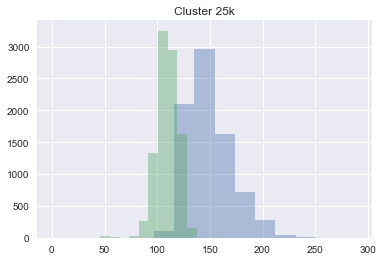

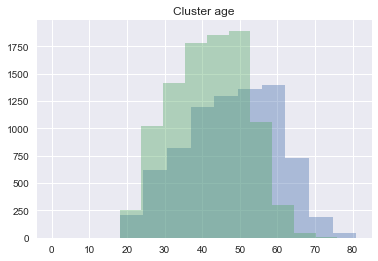

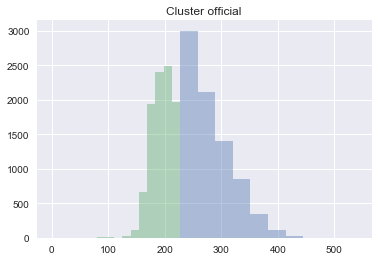

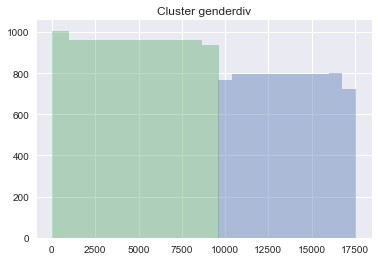

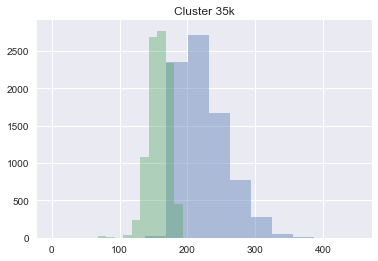

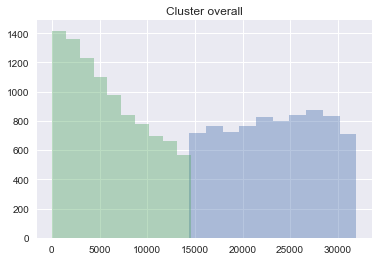

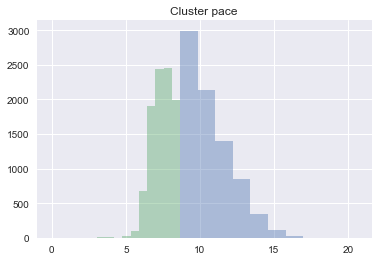

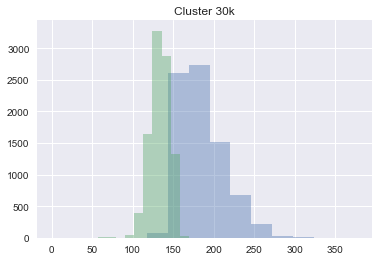

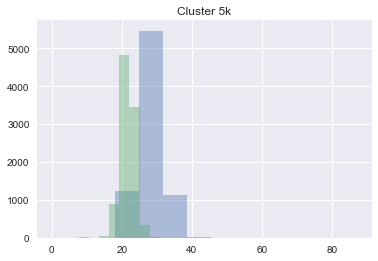

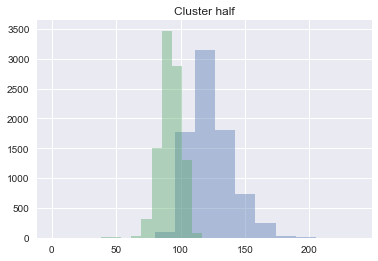

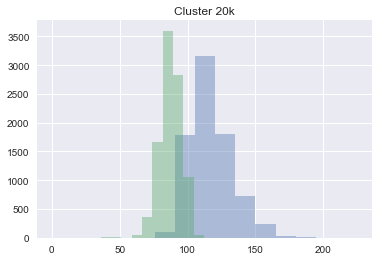

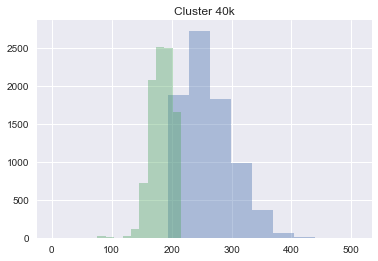

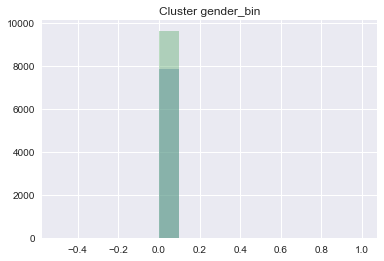

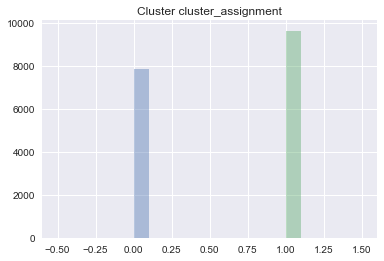

"            \n    for name, frame in cluster_dataframes.items():\n        histogrid.hist(frame[])\n\n\nfor column in numeric:\n    plt.hist(female[column])\n    plt.title(column)\n    plt.show()\n    \nf, plotgrid = plt.subplots(2, 2)\n        sil_scores = []\n\n        for i in range(4):\n\n            current_group = (f'clust{nclust}_sample{i}')\n\n            x_plot = plot_clusters[f'pca_f1_sample{i}']\n            y_plot = plot_clusters[f'pca_f2_sample{i}']\n\n            c = plot_clusters[current_group]\n\n            rows = int(np.floor(i / 2))\n                # 0,0,1,1\n            cols = i % 2\n                # 0,1,0,1\n\n            plotgrid[rows, cols].scatter(x_plot, y_plot, color = colors[c])\n            plotgrid[rows, cols].set_title(f'sample {i}')\n            plotgrid[rows, cols].set_xlim([-.3, .3])\n            plotgrid[rows, cols].set_ylim([-.3, .3])\n\n"

In [11]:
def plot_histo(X, best_cluster_num):
    cluster_dataframes = {}
    for n_clust in range(best_cluster_num):
         cluster_dataframes[n_clust] = X.loc[X['cluster_assignment'] == n_clust]
            
    print(len(X.columns))
    
    for column in X:
        for i in range(best_cluster_num):
            plt.hist(cluster_dataframes[i][column], alpha=0.4)
        plt.title(f'Cluster {column}')
        plt.show()
            
plot_histo(female_pred, female_best_cluster_num)

For the female contestants: 5k timing has the lowest spread/variance, which makes sense because at this point the race has just started, so there is less time to stand out. As the distance increases, the faster contestants maintain a sharp peak, while the slower contestants gradually start dropping off and spreading the distribution. Green is the better performing group, and blue is the worse performing group. The groups have significant overlap and a normal distribution for age, slight overlap for all the timing, the and clear cutoffs for pace, overall ranking, and official finishing time.

16


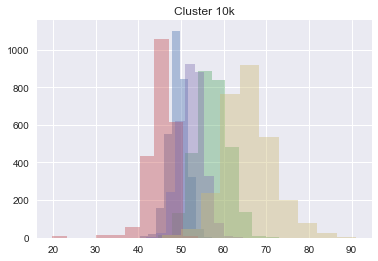

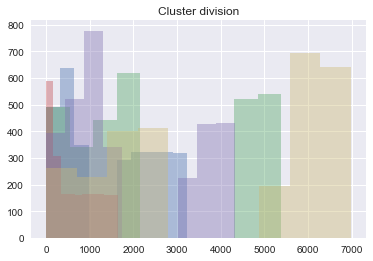

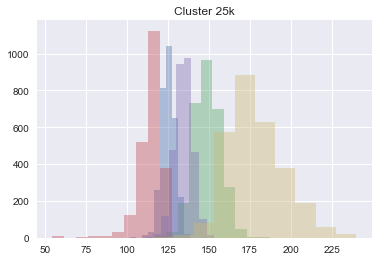

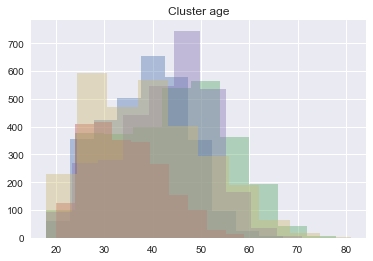

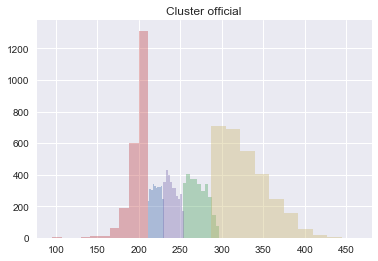

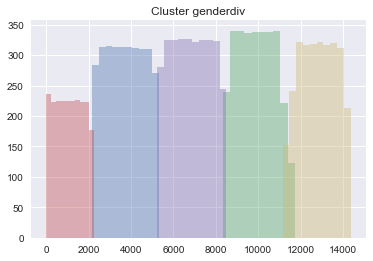

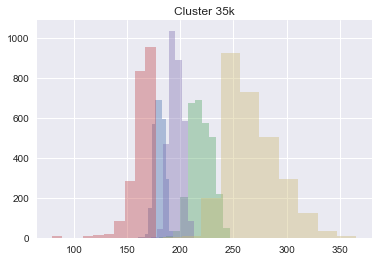

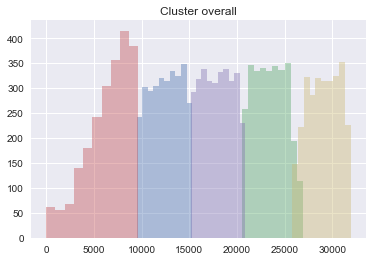

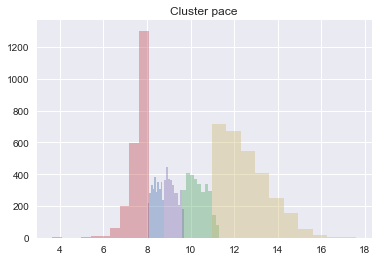

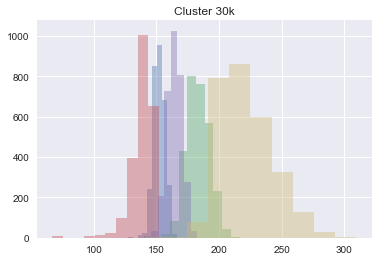

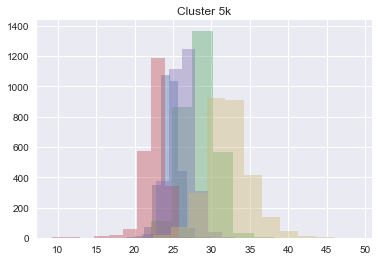

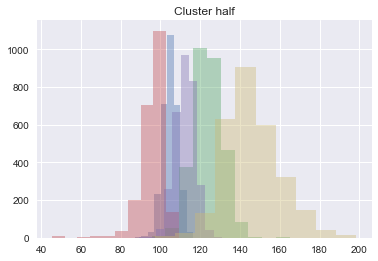

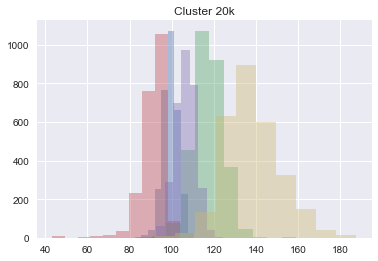

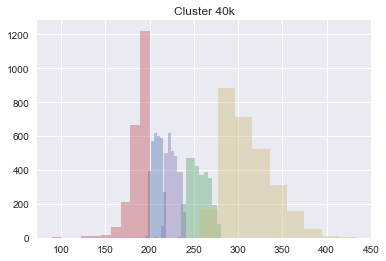

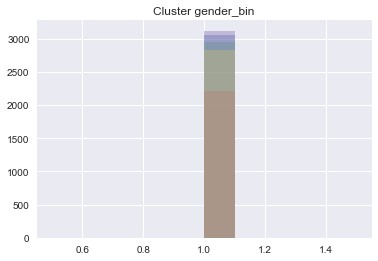

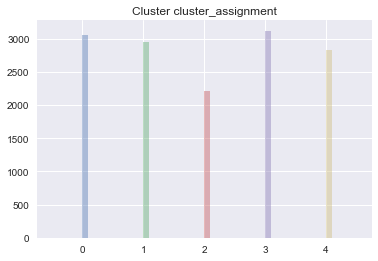

In [12]:
plot_histo(male_pred, male_best_cluster_num)

For the male clusters, the clusters consistently performed in this order (from best to worst): red, blue, purple, green, gold. Similarly to the female clusters, all of the plots for milestone timing revealed overlap between the clusters, while plots for pace, overall ranking, and official finish time have clear distinctions. The red group of highest performers tended to have the sharpest peaks, with contestants placing closer to eachother, while the lower groups had more widespread distributions. This makes sense because as we get into the clusters with slower times and lower rankings, women start diluting the pool.<br>

One interesting finding was that the red/blue/purple/green/gold order held true for every category except age, where red, blue, purple, and green were sequential but the gold group spread throughout all of these groups with a very wide distribution. The gold group, which was consistently the worst performing group, had runners as young as 18 and as old as 81. Though this surprised me at first, it makes sense considering that these are the most "newbie" marathoners, who are in it more for the sake of completing a marathon than for competition's sake. Marathon running is a culture that attracts young and old, and perhaps takes a few years of experience to start placing in higher-performing clusters.

I also found it interesting that despite having the same number of contestants for male and female, women clustered into 2 groups and men clustered into 5. With 5 clusters, you can be more specific, gathering metrics on each cluster without crazy standard deviations. 2 clusters seems like an oversimplification that masks some of the characteristics that distinguish the female contestants. Perhaps another clustering algorithm would work better; let's try mean-shift clustering.

# Mean-Shift Clustering

The estimate_bandwidth function automatically derives a bandwidth based on an inspection of the distances among points in the data. The labels function extracts cluster assignments for each data point, and n_clusters counts how many clusters there are.

labels
[0 0 0 ..., 0 0 0]
Number of estimated clusters: 11


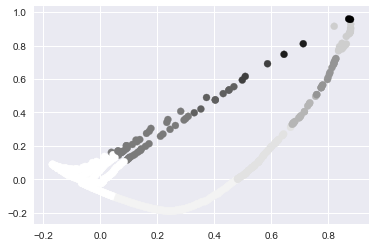

labels
[0 0 0 ..., 0 0 0]
Number of estimated clusters: 7


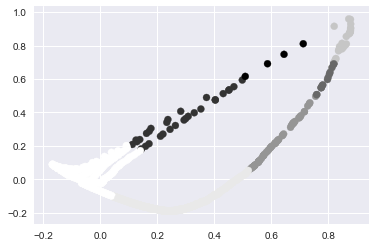

labels
[0 0 0 ..., 0 0 0]
Number of estimated clusters: 3


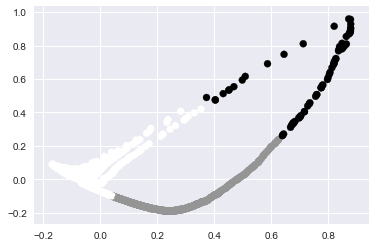

labels
[0 0 0 ..., 0 0 0]
Number of estimated clusters: 2


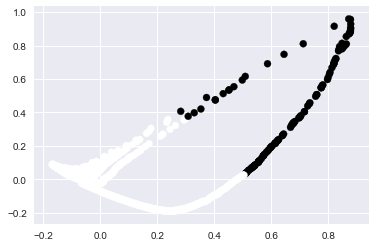

labels
[1 0 0 ..., 0 0 0]
Number of estimated clusters: 10


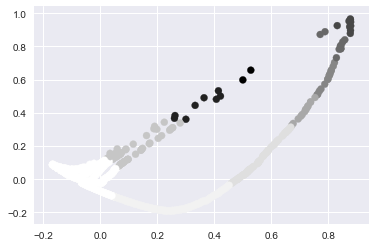

labels
[1 0 0 ..., 0 0 0]
Number of estimated clusters: 5


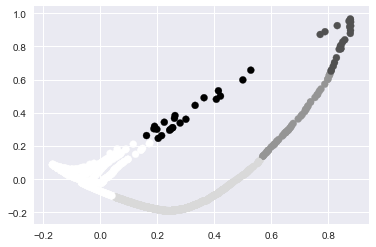

labels
[1 0 0 ..., 0 0 0]
Number of estimated clusters: 3


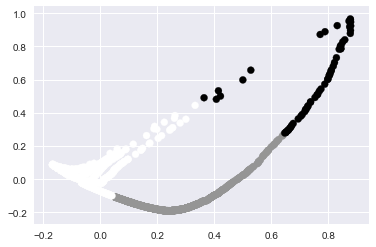

labels
[0 0 0 ..., 0 0 0]
Number of estimated clusters: 2


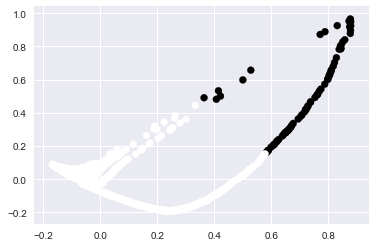

labels
[0 0 1 ..., 0 0 0]
Number of estimated clusters: 8


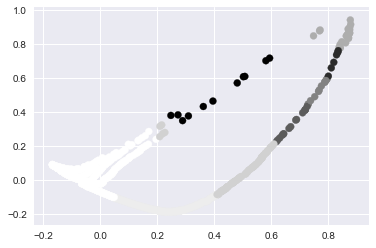

labels
[0 0 1 ..., 0 0 0]
Number of estimated clusters: 5


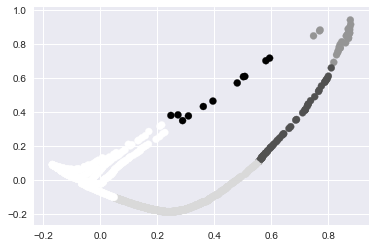

labels
[0 0 1 ..., 0 0 0]
Number of estimated clusters: 5


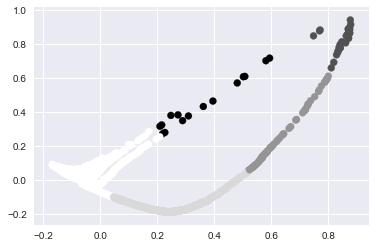

labels
[0 0 0 ..., 0 0 0]
Number of estimated clusters: 2


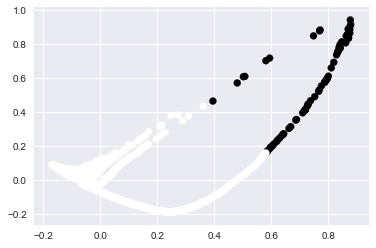

labels
[0 0 0 ..., 0 0 0]
Number of estimated clusters: 8


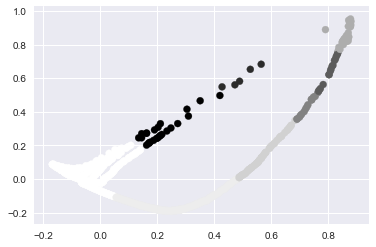

labels
[0 0 0 ..., 0 0 0]
Number of estimated clusters: 5


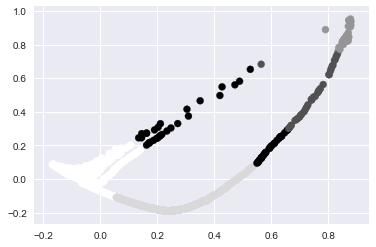

labels
[0 0 0 ..., 0 0 0]
Number of estimated clusters: 5


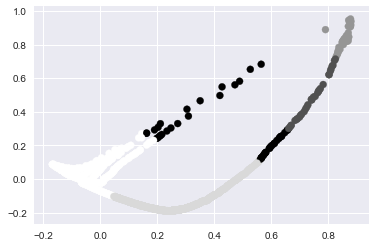

labels
[0 0 0 ..., 0 0 0]
Number of estimated clusters: 2


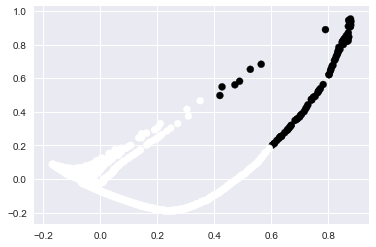

In [18]:
def evaluate_meanshift(X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4):

    plot_clusters = pd.DataFrame()
    quantile_scores = pd.DataFrame(columns=['clusters','mean score','std'])
    
    quantiles = [0.2, 0.4, 0.6, 0.8]
    for q in quantiles:
        
        for index, data in enumerate([
            (X1, X_pca1),
            (X2, X_pca2),
            (X3, X_pca3),
            (X4, X_pca4)]):

            plot_clusters['pca_f1' + '_sample' + str(index)] = data[1][:, 0]
            plot_clusters['pca_f2' + '_sample' + str(index)] = data[1][:, 1]

                bandwidth = estimate_bandwidth(data[0], quantile = q)
                ms = MeanShift(bandwidth = bandwidth)
                ms.fit(data[0])
                pred = MeanShift().fit_predict(data[0])
                ypred['quantile' + str(q) + '_sample' + str(index)] = pred

                labels = ms.labels_
                print('labels')
                print(labels)
                cluster_centers = ms.cluster_centers_
                n_clusters_ = len(np.unique(labels))

                print("Number of estimated clusters: {}".format(n_clusters_))

                plt.scatter(data[1][:, 0], data[1][:, 1], c=labels)
                plt.show()

        

evaluate_meanshift(f1, f_pca1, f2, f_pca2, f3, f_pca3, f4, f_pca4)

plot_clusters
   pca_f1_sample0  pca_f2_sample0
0        0.004448       -0.022293
1       -0.026797        0.001728
2       -0.146738        0.065855
3        0.009806       -0.015033
4       -0.078573        0.015874
quantile
0.2
plot_clusters
   pca_f1_sample0  pca_f2_sample0  quantile0.2_sample0  \
0        0.004448       -0.022293                    0   
1       -0.026797        0.001728                    0   
2       -0.146738        0.065855                    0   
3        0.009806       -0.015033                    0   
4       -0.078573        0.015874                    0   

   sil_score quantile0.2_sample0  n_clust quantile0.2_sample0  
0                       0.590474                           11  
1                       0.590474                           11  
2                       0.590474                           11  
3                       0.590474                           11  
4                       0.590474                           11  
labels
[0 0 0 ..., 0 0

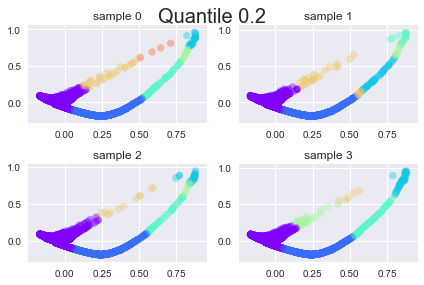



color_map[q] = 5
colors = [[  5.00000000e-01   0.00000000e+00   1.00000000e+00   1.00000000e+00]
 [  1.96078431e-03   7.09281308e-01   9.23289106e-01   1.00000000e+00]
 [  5.03921569e-01   9.99981027e-01   7.04925547e-01   1.00000000e+00]
 [  1.00000000e+00   7.00543038e-01   3.78411050e-01   1.00000000e+00]
 [  1.00000000e+00   1.22464680e-16   6.12323400e-17   1.00000000e+00]]
i=0


IndexError: index 5 is out of bounds for axis 0 with size 5

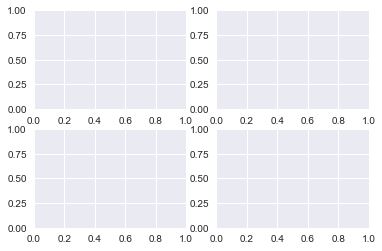

In [45]:
def evaluate_meanshift(X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4):

    plot_clusters = pd.DataFrame()
    quantile_scores = pd.DataFrame(columns=['mean_estimated_clusters','mean score','std'])
    #quantiles = [0.2, 0.4, 0.6, 0.8]
    quantiles = [0.2, 0.4]
    color_map = {}
    for q in quantiles:
        color_map[q] = 0

    for index, data in enumerate([
        (X1, X_pca1),
        (X2, X_pca2),
        (X3, X_pca3),
        (X4, X_pca4)]):

        plot_clusters['pca_f1' + '_sample' + str(index)] = data[1][:, 0]
        plot_clusters['pca_f2' + '_sample' + str(index)] = data[1][:, 1]

        print('plot_clusters')
        print(plot_clusters.head())
        
        for q in quantiles:
            bandwidth = estimate_bandwidth(data[0], quantile = q)
            ms = MeanShift(bandwidth = bandwidth)
            ms.fit(data[0])
            cluster_pred = MeanShift().fit_predict(data[0])
            
            labels = ms.labels_
            cluster_centers = ms.cluster_centers_
            n_clusters_ = len(np.unique(labels))
            
            plot_clusters['quantile' + str(q) + '_sample' + str(index)] = cluster_pred
            plot_clusters['sil_score quantile' + str(q) + '_sample' + str(index)] = \
                                metrics.silhouette_score(data[0], labels, metric='euclidean')
            plot_clusters['n_clust quantile' + str(q) + '_sample' + str(index)] = n_clusters_
            color_map[q] = n_clusters_
            
            print('quantile')
            print(q)
            print('plot_clusters')
            print(plot_clusters.head())
            
            print('labels')
            print(labels)
            
            print('n_clusters')
            print(n_clusters_)
            print('done')
            
            
    for q in quantiles:

        colors = cm.rainbow(np.linspace(0, 1, color_map[q]))
        print(f'color_map[q] = {color_map[q]}')
        print(f'colors = {colors}')
        f, plotgrid = plt.subplots(2, 2)
        cluster_estimates = []
        sil_scores = []

        for i in range(4):

            current_group = (f'quantile{q}_sample{i}')

            x_plot = plot_clusters[f'pca_f1_sample{i}']
            y_plot = plot_clusters[f'pca_f2_sample{i}']

            c = plot_clusters[current_group]

            rows = int(np.floor(i / 2))
                # 0,0,1,1
            cols = i % 2
                # 0,1,0,1
            
            print(f'i={i}')

            plotgrid[rows, cols].scatter(x_plot, y_plot, color = colors[c], alpha = 0.4)
            plotgrid[rows, cols].set_title(f'sample {i}')
            #plotgrid[rows, cols].set_xlim([-.3, .3])
            #plotgrid[rows, cols].set_ylim([-.3, .3])

            sil_score = plot_clusters['sil_score ' + str(current_group)].mean()
            sil_scores.append(sil_score)
            cluster_estimate = plot_clusters['n_clust ' + str(current_group)].mean()
            cluster_estimates.append(cluster_estimate)

        group_sil_scores_mean = np.mean(sil_scores)
        group_sil_scores_std = np.std(sil_scores)
        group_cluster_estimate = np.mean(cluster_estimates)
        quantile_scores = quantile_scores.append({'mean_estimated_clusters': group_cluster_estimate, 'quantile':q, 'mean score': group_sil_scores_mean, 'std': group_sil_scores_std}, ignore_index=True)
        print('quantile silhouette scores:')
        print(quantile_scores)

        plt.suptitle(f'Quantile {q}', fontsize=20)
        plt.tight_layout()
        plt.show()
        print('\n')
    
    print('sorted quantile scores:')
    sorted_scores = quantile_scores.sort(columns = 'mean score', ascending = False)
    print(sorted_scores)

    best_cluster_num = int(sorted_scores['quantile'].iloc[0])
    print('best cluster num:')
    print(best_cluster_num)
    
    return best_cluster_num
    

female_ms_cluster_num = evaluate_meanshift(f1, f_pca1, f2, f_pca2, f3, f_pca3, f4, f_pca4)


In [ ]:
def investigate_ms(X, best_cluster_num):
    best_cluster_pred = KMeans(n_clusters=best_cluster_num, random_state=42).fit_predict(X)
    X_pred = X.copy()
    X_pred['cluster_assignment'] = best_cluster_pred

    cluster_dataframes = {}
    for n_clust in range(best_cluster_num):
        cluster_dataframes[n_clust] = X_pred.loc[X_pred['cluster_assignment'] == n_clust]

    for name, frame in cluster_dataframes.items():
        print(name)
        print(frame.describe())
        
    return X_pred

continuous2014_pred = investigate_kmeans(continuous2014, continuous2014_best_cluster_num)

# Spectral Clustering

For spectral clustering, we must define that we are looking for 3 clusters.

In [ ]:
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    for nclust in range(17):
        pred = SpectralClustering(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
    
for cluster in range(17):
    
    f, axarr = plt.subplots(2, 2)
    
    for i in range(4):

        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        c = ypred['clust{}_sample{}'.format(cluster, i)]

        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

Maybe I can't do this because it takes too long to calculate the similarity matrix.

# Affinity Propagation

In [ ]:
af = AffinityPropagation().fit(X_train)
print('Done')

cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

Cycle through each cluster and graph them with a center point for the exemplar and lines from the exemplar to each data point in the cluster.

In [ ]:
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers_indices[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

# DRILL: Mo' blobs, mo' problems?

You've seen how these three methods work on three blobs of reasonably separated data. Now go back and change the data. Create more or fewer blobs, and set the blobs closer together or farther apart. Set up at least three different blob configurations, then run the four methods ( kk -means, mean shift, spectral clustering and affinity propagation) on each one. Write up a report for your mentor where you discuss what you learned about the clustering methods based on their relative performance for your different blob setups.

First, I will use 2 clusters, further apart, and with very small standard deviations.

In [ ]:
centers1 = [[6, 12], [-2, -6]]

X1, y1 = make_blobs(
    n_samples=8000,
    centers=centers1,
    cluster_std=.5,
    n_features=2,
    random_state=42)

plt.scatter(X1[:, 0], X1[:, 1], c=y1)
plt.show()

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1,
    y1,
    test_size=0.9,
    random_state=42)

In [ ]:
def k_means(X_train, y_train, X_test, y_test, n_clus):

    kms = KMeans(n_clusters=n_clus, random_state=42)
    kms.fit(X_train)
    
    train_predict = kms.fit_predict(X_train)
    test_predict = kms.fit_predict(X_test)
    
    plt.scatter(X_train[:, 0], X_train[:, 1], c=train_predict)
    plt.show()
    
    print('Training Accuracy:')
    print(pd.crosstab(y_train,train_predict))
    print('Testing Accuracy:')
    print(pd.crosstab(y_test,test_predict))
    
k_means(X1_train, y1_train, X1_test, y1_test, 2)

Wow! Using normal K-means clustering, both training and testing accuracy are perfect. For the training data, the model accurately predicts the cluster 0% of the time, which is fine. It is interesting that the case is reversed in the testing data. With K-meas, we must specify the number of clusters we are looking for ahead of time. Let's try mean-shift.<br>

Note: the quantile function for bandwidth affects the type of pairwise distances used, quantile = 0.5 uses the median pair of all pairwise ditances. Setting a lower quantile creates more clusters.

In [ ]:
def mean_shift(X_train, y_train, X_test, y_test):
    bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X_train)

    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = len(np.unique(labels))

    print("Number of estimated clusters: {}".format(n_clusters_))
    
    plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
    plt.show()
    
    test_predict = ms.fit_predict(X_test)

    print('Training Accuracy:')
    print(pd.crosstab(y_train,labels))
    print('Testing Accuracy:')
    print(pd.crosstab(y_test,test_predict))
    
mean_shift(X1_train, y1_train, X1_test, y1_test)

Mean-shift This estimates the number of clusters for you, as opposed to the user having to specify the number of clusters. It also has perfect accuracy for both training and testing, though the clusters are reversed. Let's try spectral clustering.<br>

Note: the default similarity measure is RBF.

In [ ]:
def spectral_clustering(X_train, y_train, X_test, y_test, n_clus):

    sc = SpectralClustering(n_clusters=n_clus, random_state=42)
    sc.fit(X_train)
    
    train_predict = sc.fit_predict(X_train)
    
    
    plt.scatter(X_train[:, 0], X_train[:, 1], c=train_predict)
    plt.show()

    test_predict = sc.fit_predict(X_test)
    
    print('Training Accuracy:')
    print(pd.crosstab(y_train,train_predict))
    print('Testing Accuracy:')
    print(pd.crosstab(y_test, test_predict))
    
spectral_clustering(X1_train, y1_train, X1_test, y1_test, 2)

Spectral clustering (which quantifies similarity between datapoint pairs) misclassified each cluster 100% of the time, which makes it very accurate if you simply switch the clusters. This might be because we set a very small standard deviation, so all points are pretty uniform with eachother and easy to make sense of in a similarity matrix. One potential drawback is that **we have to specify the number of clusters** we are looking for.

In [ ]:
def affinity_prop(X_train, y_train, X_test, y_test):

    af = AffinityPropagation().fit(X_train)

    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    labels = af.labels_

    print('Estimated number of clusters: {}'.format(n_clusters_))

    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for k, col in zip(range(n_clusters_), colors):
        class_members = labels == k
        cluster_center = X_train[cluster_centers_indices[k]]
        plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
        plt.plot(cluster_center[0],
                 cluster_center[1],
                 'o',
                 markerfacecolor=col,
                 markeredgecolor='k')
        for x in X_train[class_members]:
            plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

    plt.title('Estimated number of clusters: {}'.format(n_clusters_))
    plt.show()

affinity_prop(X1_train, y1_train, X1_test, y1_test)

We can see here that affinity propagation estimated 105 clusters for a very simple 2 clusters. This is not an appropriate choice for this problem, especially because it is computationally expensive. Affinity propagation is better suited for enormous and diverse sets of data with many clusters.<br>

Let's make another set of clusters to play with.

In [ ]:
centers2 = [[57, 25], [-7, -24],[0,0]]

X2, y2 = make_blobs(
    n_samples=1000,
    centers=centers2,
    cluster_std=8,
    n_features=2,
    random_state=42)

plt.scatter(X2[:, 0], X2[:, 1], c=y2, alpha = 0.5)
plt.show()

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2,
    y2,
    test_size=0.4,
    random_state=42)

These clusters have a much higher standard deviation (2 of them actually bleed into eachother) and have fewer points in the clusters. I expect this will make it harder to classify, since there is less training/validation data and higher variance. The last dataset was trained on 10% and validated on 90%, but because of the smaller size of this dataset, I will train it on 60%.

In [ ]:
k_means(X2_train, y2_train, X2_test, y2_test, 3)

At default settings, **conventional k-means** performed pretty well. Out of 544 test points, only 15 were misclassified. This is about a 97.5% accuracy. This dataset was relatively small, so k-means was manageable in terms of computational simplicity.

In [ ]:
mean_shift(X2_train, y2_train, X2_test, y2_test)

Using **mean-shift clustering**, we were able to predict the correct number of clusters, misclassifying 17 datapoints. This is ever so slightly worse than conventional k-means, but doesn't require us to know the number of clusters. This could be an advantage, depending on the scenario.

In [ ]:
spectral_clustering(X2_train, y2_train, X2_test, y2_test, 3)

**Spectral clustering** seemed to take much longer than the other 2 methods. This is because of the time it takes to calculate the n x n similarity matrix. It also pretty much got everything wrong! We didn't specify the type of affinity to use, or n_components. We could raise the n_init (Number of time the k-means algorithm will be run with different centroid seeds) but this would make the cell run even longer.

In [ ]:
affinity_prop(X2_train, y2_train, X2_test, y2_test)

I find it very interesting that in the previous dataset, with two distinct, uniform, clusters (a relatively easy dataset to classify) the affinity propagation algorithm grossly overestimated the number of clusters (3 to 105) but with this dataset, it only estimated 18 for 3 real clusters. This must be because the clusters had a much higher standard deviation, so the "randomness" of the datapoints lent themselves well to clustering. In the previous dataset, the data was so uniform that even the smallest deviation could warrant making a new cluster. Still, this algorithm is too complex for this dataset so I wouldn't choose to use this in real life.<br>

Time to make our last dataset!

In [ ]:
centers3 = [[30, 25],[-7, -15],[0,0],[10,10],[-2,4],[10,0]]

X3, y3 = make_blobs(
    n_samples=5000,
    centers=centers3,
    cluster_std=3,
    n_features=2,
    random_state=42)

plt.scatter(X3[:, 0], X3[:, 1], c=y3, alpha = 0.5)
plt.show()

X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3,
    y3,
    test_size=0.4,
    random_state=42)

This dataset has 6 clusters, 4 of which are very closely intertwined. One more is straggling nearby, and the last one is clearly off in its own space. It will be interesting to see if these methods can distinguish between these clusters.

In [ ]:
k_means(X3_train, y3_train, X3_test, y3_test, 6)

Without titrating the parameters accordingly, K-means misclassifed some of the points, but did alright overall. Clusters 2 and 4 had the worst accuracy. Cluster 0 was perfect, and cluster 1 was nearly perfect. This could be improved by raising the max_iter (default = 300).

In [ ]:
mean_shift(X3_train, y3_train, X3_test, y3_test)

Despite the quantile being set pretty low, the **mean shift algorithm** estimated too few clusters. I am just using the default settings here in the interest of time, but ways that I could fix this include altering the quantile. This would change the way the bandwidth is estimated, we would want a smaller bandwidth for a rougher surface, allowing for more clusters. We could also increase n_jobs, the number of jobs used in the computation.

In [ ]:
spectral_clustering(X3_train, y3_train, X3_test, y3_test, 6)

This result is very interesting -- with **spectral clustering**, 5 clusters are defined within the interior of one massive, varied, and far-reaching cluster. The various centroids of each cluster and their immediate surroundings are classified as separate from the outskirts. All clusters have a high degree of error. To address this, we could try altering the quantile or eigenvalue decomposition strategy, increase the n_init (number of times the algorithm is run with different centroid seeds), and tinkering with the gamma kernel coefficient.

In [ ]:
affinity_prop(X3_train, y3_train, X3_test, y3_test)

Yet again, **affinity propagation** has shown itself to be too complicated for the likes of this problem. It is however, interesting to note that the most easily defined cluster (far off to the right) was only split up into 4 decently sized clusters, whereas the clusters that are running into eachother were split up into hundreds of micro-clusters. with a relatively high variance and so much overlapping data, this is unsurprising.

# Conclusion

Overall, we see that k-means has performed very strongly with these fairly simple clustering tasks. K-means is versatile with many tunable parameters, and is quite useful when the number of clusters is known. Mean-shift showed similar results as k-means, miss distinctions between clusters and oversimplify the data. Mean-shift is comparable but is more often used when the number of desired clusters is not known. Spectral clustering tended to complicate the clusters, splitting clusters up into inner/outer clusters, and generally missing the mark. This technique should be used when the number of clusters are known, and perhaps when the task at hand is relatively complex, as it tends to complicate the simpler clusters. Affinity propagation should be reserved for extremely complex tasks where the number of clusters is not known.